In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from IPython.display import display, Markdown


In [2]:
df = pd.read_csv('HB2025stats.csv')


In [3]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,9/24/2025,95.1,-2.18,6.10,"Brown, Hunter",805779,686613,field_out,hit_into_play,...,1.0,1.20,0.65,0.65,57.3,12.29261,-4.947087,25.089275,33.658583,31.278352
1,SI,9/24/2025,92.8,-2.13,6.16,"Brown, Hunter",805779,686613,NaN,ball,...,1.0,1.70,1.08,1.08,51.2,NaN,NaN,NaN,NaN,NaN
2,FF,9/24/2025,96.6,-1.98,6.29,"Brown, Hunter",805779,686613,NaN,ball,...,1.0,1.05,0.44,0.44,59.5,NaN,NaN,NaN,NaN,NaN
3,SI,9/24/2025,94.4,-2.47,6.02,"Brown, Hunter",805779,686613,NaN,ball,...,1.0,1.56,1.37,1.37,47.6,NaN,NaN,NaN,NaN,NaN
4,SI,9/24/2025,97.3,-1.93,6.25,"Brown, Hunter",805779,686613,NaN,called_strike,...,1.0,1.21,0.91,0.91,56.2,NaN,NaN,NaN,NaN,NaN


In [4]:
y = df['pitch_type']

In [5]:
df.shape

(8571, 118)

In [6]:
#finding NA's and comparing them to the total count of the rows, then producing a list of columns with a high percentage of Na's
na_counts = df.isnull().sum()
na_percentage = (na_counts / len(df)) * 100
na_percentage = na_percentage.sort_values(ascending=False)
target_na_count = 8571
cols_to_drop = na_counts[na_counts == target_na_count].index

na_percentage


spin_dir                   100.0
spin_rate_deprecated       100.0
tfs_deprecated             100.0
break_length_deprecated    100.0
break_angle_deprecated     100.0
                           ...  
vy0                          0.0
vx0                          0.0
inning_topbot                0.0
inning                       0.0
fielder_3                    0.0
Length: 118, dtype: float64

In [7]:
#setting a critera on which columns to drop based on missing data percentage
missing_data = na_percentage[na_percentage > 0]
high_na_cols = missing_data[missing_data > 50].index.tolist()

In [8]:
#finding the columns that are deprecated
deprecated_cols = [col for col in df.columns if 'deprecated' in col.lower()]

In [9]:
#certain columns may have zero variance (only one unique value) such as the Pitcher Name
unique_counts = df.nunique()
zero_variance_cols = unique_counts[unique_counts == 1].index.tolist()

In [10]:
#combining all columns to drop into a single list
all_drop_cols = list(set(high_na_cols + zero_variance_cols + deprecated_cols))

all_drop_cols

['tfs_zulu_deprecated',
 'swing_length',
 'umpire',
 'hit_location',
 'estimated_slg_using_speedangle',
 'launch_angle',
 'bat_speed',
 'woba_value',
 'hit_distance_sc',
 'attack_angle',
 'hc_y',
 'launch_speed',
 'hyper_speed',
 'iso_value',
 'tfs_deprecated',
 'events',
 'spin_dir',
 'hc_x',
 'on_3b',
 'launch_speed_angle',
 'sv_id',
 'intercept_ball_minus_batter_pos_y_inches',
 'spin_rate_deprecated',
 'game_type',
 'break_length_deprecated',
 'break_angle_deprecated',
 'estimated_ba_using_speedangle',
 'on_1b',
 'estimated_woba_using_speedangle',
 'pitcher',
 'player_name',
 'woba_denom',
 'babip_value',
 'bb_type',
 'attack_direction',
 'p_throws',
 'intercept_ball_minus_batter_pos_x_inches',
 'swing_path_tilt',
 'on_2b']

In [11]:
# Ensure our target 'pitch_type' is NOT in the drop list
if 'pitch_type' in all_drop_cols:
    all_drop_cols.remove('pitch_type')
    print("Note: 'pitch_type' was in drop list, but removed as it is the target.")

print(f"Total columns to be dropped: {len(all_drop_cols)}")


Total columns to be dropped: 39


In [12]:
# Create X by dropping the target and all identified columns
X = df.drop(columns=all_drop_cols + ['pitch_type'])

In [13]:
# Create y as the target variable
na_target_rows = y.isnull()
if na_target_rows.any():
    X = X[~na_target_rows]
    y = y[~na_target_rows]

In [14]:
#showing the shapes of X and y after dropping rows with NaN target values
X.shape, y.shape

((8571, 78), (8571,))

In [15]:
#feature engineering, creating new features based on existing data, transmuting them to 0/1 indicators
df['on_1b'] = (~df['on_1b'].isnull()).astype(int)
df['on_2b'] = (~df['on_2b'].isnull()).astype(int)
df['on_3b'] = (~df['on_3b'].isnull()).astype(int)

In [16]:
#creating features based on the previous pitch in the same at-bat
df = df.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])

grouped = df.groupby(['game_pk', 'at_bat_number'])
df['prev_pitch_type'] = grouped['pitch_type'].shift(1)
df['prev_pitch_result'] = grouped['type'].shift(1) # 'type' contains 'S', 'B', 'X'

/var/folders/y5/tp3w___j6db3_24msq581rdh0000gn/T/ipykernel_35010/972124528.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['prev_pitch_type'] = grouped['pitch_type'].shift(1)
/var/folders/y5/tp3w___j6db3_24msq581rdh0000gn/T/ipykernel_35010/972124528.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['prev_pitch_result'] = grouped['type'].shift(1) # 'type' contains 'S', 'B', 'X'


In [17]:
# These are all known *before* the pitch is thrown. Creating a feature matrix

situational_features = [
    #Game State
    'inning', 'outs_when_up', 'balls', 'strikes',
    #Score
    'bat_score', 'fld_score',
    #Base Runners
    'on_1b', 'on_2b', 'on_3b',
    #Batter/Fielding
    'stand', 'if_fielding_alignment', 'of_fielding_alignment',
    #Lagged Feature
    'prev_pitch_type', 'prev_pitch_result'
    ]

In [18]:
X = df[situational_features]
y = df['pitch_type']

In [19]:
# drop any row that now has a NaN value. This will primarily be the first pitch of every at-bat (which has no 'previous' pitch)

full_data = pd.concat([X, y], axis=1)

# Drop all rows with any NaNs (from lagged features or any other column)

full_data_cleaned = full_data.dropna()

X_cleaned = full_data_cleaned.drop(columns=['pitch_type'])
y_cleaned = full_data_cleaned['pitch_type']



In [20]:
#creating preprocess pipeline for both numerical and categorical features
    
    # Numerical features
numerical_features = [
    'balls', 'strikes', 'outs_when_up', 'inning', 'bat_score', 'fld_score', 'on_1b', 'on_2b', 'on_3b'
]

categorical_features = [
    'stand', 'if_fielding_alignment', 'of_fielding_alignment', 'prev_pitch_type', 'prev_pitch_result'
]

numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Impute just in case
        ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

In [22]:
#createing a pipeline for the Naive Bayes model
bayes_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Use the *same* unfitted preprocessor
        ('model', GaussianNB())
    ])

# 2. Fit the Naive Bayes pipeline on the training data
bayes_pipeline.fit(X_train, y_train)

# 3. Predict using the test data
# The pipeline automatically processes X_test before predicting
y_pred_bayes = bayes_pipeline.predict(X_test)

report_string = classification_report(y_test, y_pred_bayes, zero_division=0)    




In [23]:
markdown_output = f"""
## Classification Report
{report_string}
"""
display(Markdown(markdown_output))


## Classification Report
              precision    recall  f1-score   support

          CH       0.23      0.33      0.28       138
          FC       1.00      0.01      0.01       190
          FF       0.00      0.00      0.00       506
          KC       0.00      0.00      0.00       235
          SI       0.41      0.47      0.44       171
          SL       0.25      0.32      0.28        44
          ST       0.01      1.00      0.02         7

    accuracy                           0.12      1291
   macro avg       0.27      0.30      0.15      1291
weighted avg       0.23      0.12      0.10      1291



Text(89.59722222222221, 0.5, 'Actual Pitch Type')

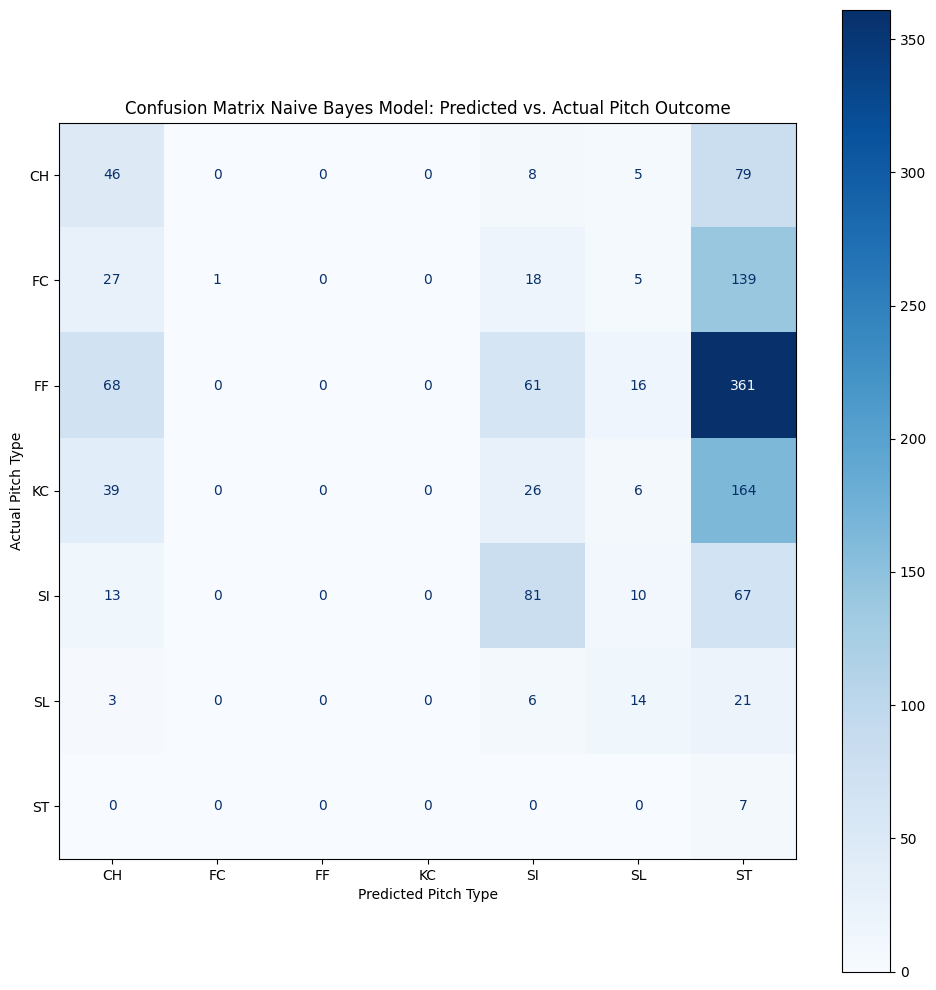

In [24]:
class_labels = bayes_pipeline.classes_

cm1 = confusion_matrix(y_test, y_pred_bayes, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='horizontal')
plt.title("Confusion Matrix Naive Bayes Model: Predicted vs. Actual Pitch Outcome")
plt.tight_layout()
plt.xlabel("Predicted Pitch Type")
plt.ylabel("Actual Pitch Type")

In [25]:
#tuning hyper params
clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Use the *same* unfitted preprocessor
        ('model', RandomForestClassifier(random_state=42))
    ])
parameters = {
    'model__n_estimators': [100, 300, 500, 1000, 10000],
    'model__max_depth': [None, 10, 20,30,40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=clf_pipeline,
    param_distributions=parameters,
    n_iter=75,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)




Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=300; total time=   0.8s
[CV] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=500; total time=   1.7s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=10000; total time=  31.7s


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1000; total time=   2.6s
[CV] END model__max_depth=40, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=10000; total time=  32.0s
[CV] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=300; total time=   1.0s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=10000; total time=  40.5s
[CV] END model__max_depth=20, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300; total time=   1.3s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1000; total time=   3.9s
[CV] END model__max_depth=None, model__max_features=log2, 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
69 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File 

[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=10000; total time=  54.4s
[CV] END model__max_depth=40, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=10000; total time=   0.0s
[CV] END model__max_depth=40, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=10000; total time=   0.0s
[CV] END model__max_depth=40, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=10000; total time=   0.0s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=100; total time=   0.4s
[CV] END model__max_depth=10, model__max_features=sqrt, 

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [None, 10, ...], 'model__max_features': ['auto', 'sqrt', ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,n_iter,75
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [26]:
print("Best parameters found:")
random_search.best_params_

Best parameters found:


{'model__n_estimators': 100,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 4,
 'model__max_features': 'log2',
 'model__max_depth': 10}

In [27]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)
markdown_output = f"""
## Classification Report
{report}
"""
display(Markdown(markdown_output))




## Classification Report
              precision    recall  f1-score   support

          CH       0.36      0.04      0.07       138
          FC       0.30      0.13      0.18       190
          FF       0.43      0.82      0.56       506
          KC       0.41      0.14      0.21       235
          SI       0.54      0.43      0.48       171
          SL       0.00      0.00      0.00        44
          ST       0.00      0.00      0.00         7

    accuracy                           0.43      1291
   macro avg       0.29      0.22      0.21      1291
weighted avg       0.40      0.43      0.36      1291



Text(89.59722222222221, 0.5, 'Actual Pitch Type')

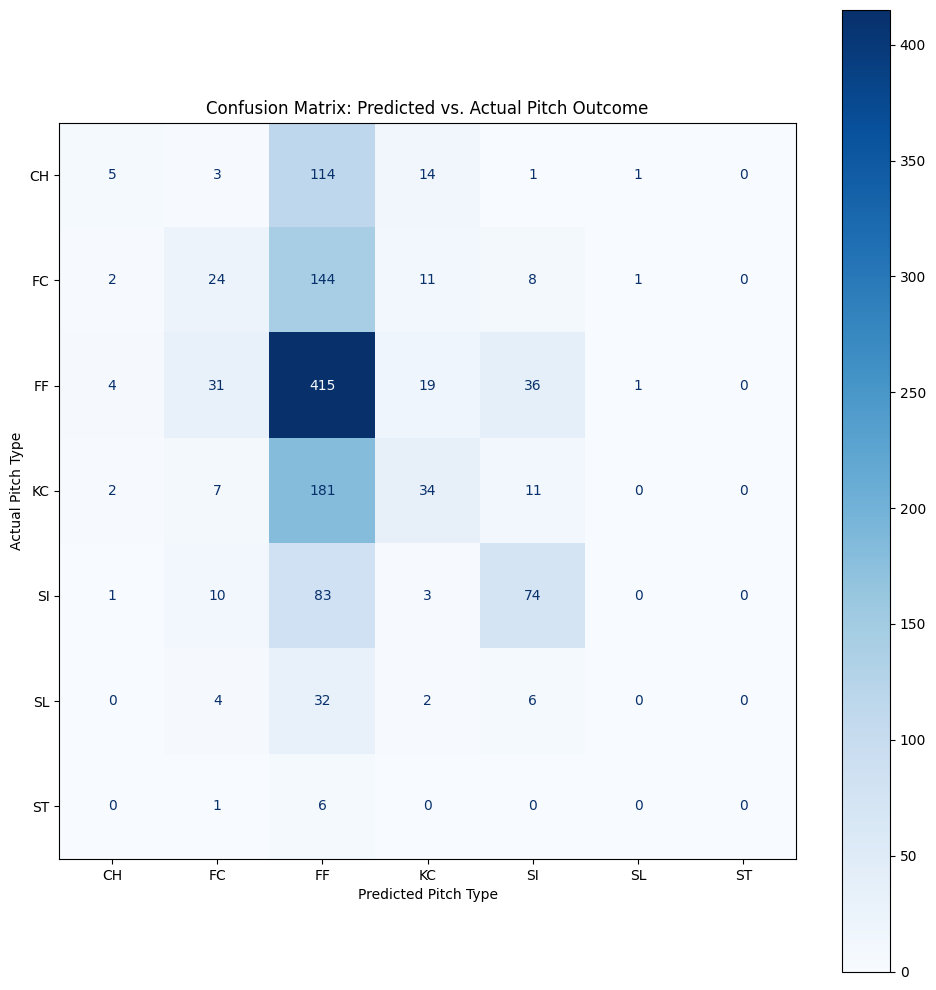

In [28]:
class_labels = best_model.classes_

cm2 = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='horizontal')
plt.title("Confusion Matrix: Predicted vs. Actual Pitch Outcome")
plt.tight_layout()
plt.xlabel("Predicted Pitch Type")
plt.ylabel("Actual Pitch Type")

In [29]:
import nbformat

# Load the broken notebook
with open('PitchPredictor.ipynb', 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# nbformat will automatically fill in missing required fields
# like execution_count when saving
with open('PitchPredictor.ipynb', 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)